# Inverse Kinematics and PID control
In this homework assignemnt, you will be tasked with creating an IK solver and controlling a robot arm using PID control (specifically the Franka Panda 7DoF robot). We will be creating two versions of the controller, one that uses pure velocity control and another that using torque control with feedforward dynamics. 

### Import mujoco and numpy

In [1]:
import mujoco
import mujoco_viewer
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt # add for plot

from autograder import autograder
from sim import Sim

franka_velocity_ctrl_sim = Sim(fname='./franka_emika_panda/scene_velocity_actuators.xml')
franka_torque_ctrl_sim = Sim(fname='./franka_emika_panda/scene_torque_actuators.xml')


### Robot Info: Franka Emika Panda Robot
We will be importing the Franka Panda robot. Take a look at the robot tree in `franka_emika_panda/panda.xml` file. Rather than importing the robot, we will instead import a specific `scene_X.xml` file that specifies different joint actuation on the robot. Note that the `panda.xml` only specifies the robot body and joints. There are two other files that specify the type of actuation on the robot (`vel_act.xml` and `torque_act.xml`) which we will use to demonstrate the different levels of robot control. 

### Assignment Questions 
Go through this notebook and answer all the questions below. There are autograder helpers which will tell you whether you have good code or not. Please use those to ensure that you can safely move on the next problem. This will prevent any bugs from being carried over to the next problem.

## Rotation matrices and error signal
Before we begin, you need to write up a few functions that will help you compute errors on rotation matrices that you will use to control the robot. First, we will write two helper functions `hat` and `unhat` which converts vectors in $\mathbb{R}^3 \to \text{se}(3)$ and back. This will be used when you compute the distance between two rotation matrices. Specifically, the error between two rotation matrices can be defined using the axis-angle formulation when we discussed exponential coordinates. Recall that $R = e^{\hat{\omega}\theta}$ which is a rotation in some axis $\omega$ by the amount of $\theta$. We can convert $R$ into its components $\hat{\omega} \theta \in \mathbb{R}^3$ by using the matrix logarithm $\text{logm}$. We will then need to convert the resulting matrix back into $\mathbb{R}^3$ using the `unhat` operator. We will be using the scipy library to compute `unhat(sp.linalg.logm(R)) = w` where here `w` is combined with $\theta$. To compute the error between two rotation matrices, we simply multiply the two $R_1 R_2^\top$. For example, if $R_1 = R_{WD}$ and $R_2 = R_{WEE}$, then we want an $R$ such that $R_{WD} =R R_{WEE}$. Therefore, $R = R_{WD} R_{WEE}^\top$ is our relative rotation transform.


### Q1 a. Hat, Unhat 
Write a function `hat` that converts a vector $w\in\mathbb{R}^3 \to \text{se}(3)$ and another function `unhat` that goes the opposite direction.

In [2]:
def hat(w):
    w1 = w[0];
    w2 = w[1];
    w3 = w[2];
    W = [[0, -w3, w2],
        [w3, 0, -w1],
        [w2, w1, 0]]
    R = sp.linalg.expm(W);    
    return R

def unhat(R):
    W = sp.linalg.logm(R)
    w = [W[2,1],W[0,2],W[1,0]]
    return w


[0.9999999999999963, -1.9999999999999964, 3.0000000000000053]


In [3]:
autograder.testQ1a(hat, unhat)

Passed Debug test


### Q1 b. Rotation error
Write a function that computes the error between two rotation matrices $R_1, R_2$.

In [5]:
def rot_err(R1, R2):
    R = unhat (R1 @ np.transpose(R2))
    return R

In [6]:
autograder.testQ1b(rot_err)

Passed Debug test


## Inverse Kinematics Solver
We will now create the IK solver. We will use some helper functions to get the rotation, position, and jacobian of a site in the `.xml` file. Look through the files and find the tags for `site`. Specifically, look for the two tags `ee_site` and `target_site` within the `worldbody` tags. These will be the two target frames on a the robot and in the world respectively. Understand the functions below and answer the subsequent questions. 

In [7]:
def getSitePose(model, data, site_name):
    """
        This function takes in the robot model, data, and the site name of the reference frame. 
        The output of the function returns a tuple of a rotation matric R and a position p 
        relative to the world frame. 
    """
    # mujoco specific function
    site_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, site_name)
    # data structure for obtaining the position and orientation of a site reference frame
    # note that rotation matrices are formated as a 9-dim vector and need to be reshaped
    p = data.site_xpos[site_id]
    R = data.site_xmat[site_id].reshape((3,3))
    return (R, p)

def getSiteJacobian(model, data, site_name):
    """
        This function takes in the robot model, data, and the site name of the reference frame. 
        The output is the total jacobian matrix. Note that mujoco gives jacobian 
        position and rotation matrices which need to be stacked together.
    """
    body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_SITE, site_name)
    jacp = np.zeros((3, model.nv))
    jacr = np.zeros((3, model.nv))
    mujoco.mj_jacSite(model, data, jacp, jacr, body_id)
    return np.concatenate([jacp, jacr], axis=0)


## Q2. Write the IK step. 
Write function to compute $\Delta q$, for $q_{k+1} = q_k + \Delta q$, where $\Delta q$ is the solution to the minimum joint deviation based on the Taylor expansion of $f(q) - x_\text{des}$, and $f(q)$ is your forward kinematics (assume that this is given as x_\text{curr}).

In [8]:
def calcIKStep(jac, x_des, x_curr):
    """
        This function takes in the jacobian matrix of the x_\text{curr} = f(q) forward kinematics, 
        and the desired frame rotation matrix and position. 
        Assumes x_des, x_curr = (R, p)
        Output of this function computes $\Delta q$ using the jacobian.
    """
    # r_theta = x_des - x_curr;  
    r_theta_0 = rot_err(x_des[0],x_curr[0])
    r_theta_1 = x_des[1]-x_curr[1]
    r_theta = np.concatenate([r_theta_1, r_theta_0], axis=0)
    #r_theta[1] = 
    dq = np.linalg.pinv(jac) @ r_theta    
    return dq

def IKSolve(q, jac, x_des, x_curr):
    dq = calcIKStep(jac, x_des, x_curr)
    return q + dq


# Control!
We will now implement different control strategies to move our robot. We will use the function below to simulate the control method used. Make sure you run the cell and load the function. Note that for the following examples you need to calculate the error from the poses of the reference frames.

In [70]:
def simulateCtrl(sim, ctrl_method, render=True, t_max=1000):
    sim.data.qpos = sim.model.key_qpos
    mujoco.mj_step(sim.model, sim.data)
    log = []
    if render:
        viewer = mujoco_viewer.MujocoViewer(sim.model, sim.data)
        viewer.vopt.frame = 3
    for t in range(t_max):
        u = ctrl_method(sim.model, sim.data)        
        sim.data.ctrl = u 
        mujoco.mj_step(sim.model, sim.data)
        if render:
            if viewer.is_alive:
                viewer.render()
    if render:
        viewer.close()

## Q3 Velocity control
Create a controller that returns $\Delta q$ given the end-effector pose and the target site pose. Using the `calcIKStep` to compute $\Delta q$. Run the `simulateCtrl` using the `franka_velocity_ctrl_sim` simulation. Describe what you see. 

## Response:
When I made the return value as calcIKStep(jac, x_des, x_curr), the end-effector start to moving to the target site pose. However, duo to the gravity and robot's inertia, it is not able to move properly. Also, the input used for velocity control seemed to be small. In particular, it was possible to observe that the end-effector gradually descended downward in the z-direction and it didn't seem to be well controlled. Finally, it did not reach the correct target. So, I adapted kp to increase the amount of u. After that, the control results became better. But, it has still errors.

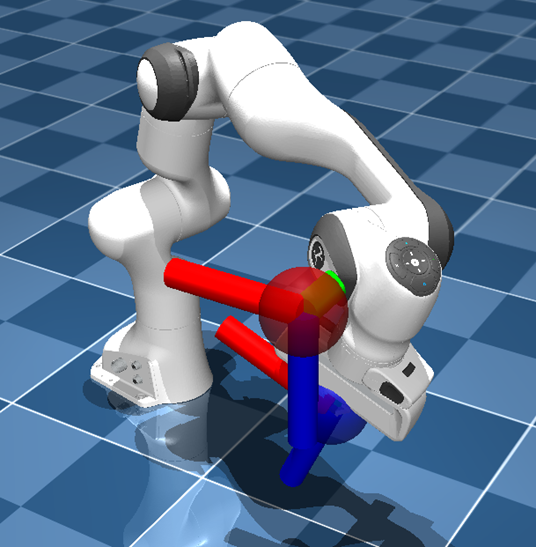 (kp = 1)

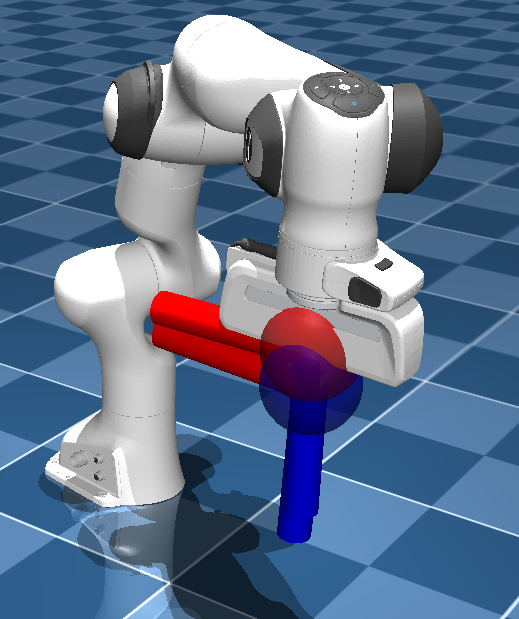 (kp = 10)


In [71]:
def velocity_ctrl(model, data):
    # r_theta = x_des - x_curr;
    #kp = 1;
    kp = 10;
    x_des = getSitePose(model, data, "target_site")
    x_curr = getSitePose(model, data, "ee_site")
    jac = getSiteJacobian(model, data, "ee_site")    
  
    return kp*calcIKStep(jac, x_des, x_curr)

In [72]:
simulateCtrl(franka_velocity_ctrl_sim, velocity_ctrl)

## Q4 Torque control
Create a  basic PD controller that calculates torque values using $q$ from the `IKSolve` given the end-effector pose and the target site pose. Tune the PD values as best as you can.Describe what you see. 

## Response:

In thie torque control case, I used PD control to contol the end-effector's postion. When I used small gain such as kp = 500, kd = 50, the control errors were quite big in steady state. To make better control performance, I also increased the control gain as kp=3000 and kd=100. Also, in reality, I think that it is impossible to increase the gain. It could make system unstable and also, there are limitation of motor torque. Moreover, in this system, the PD control could not erase the system dynamics. When the end-effector goes too close to the target position, motor inputs, u, are too small and the error become large duo to gravity and robot's inertia.

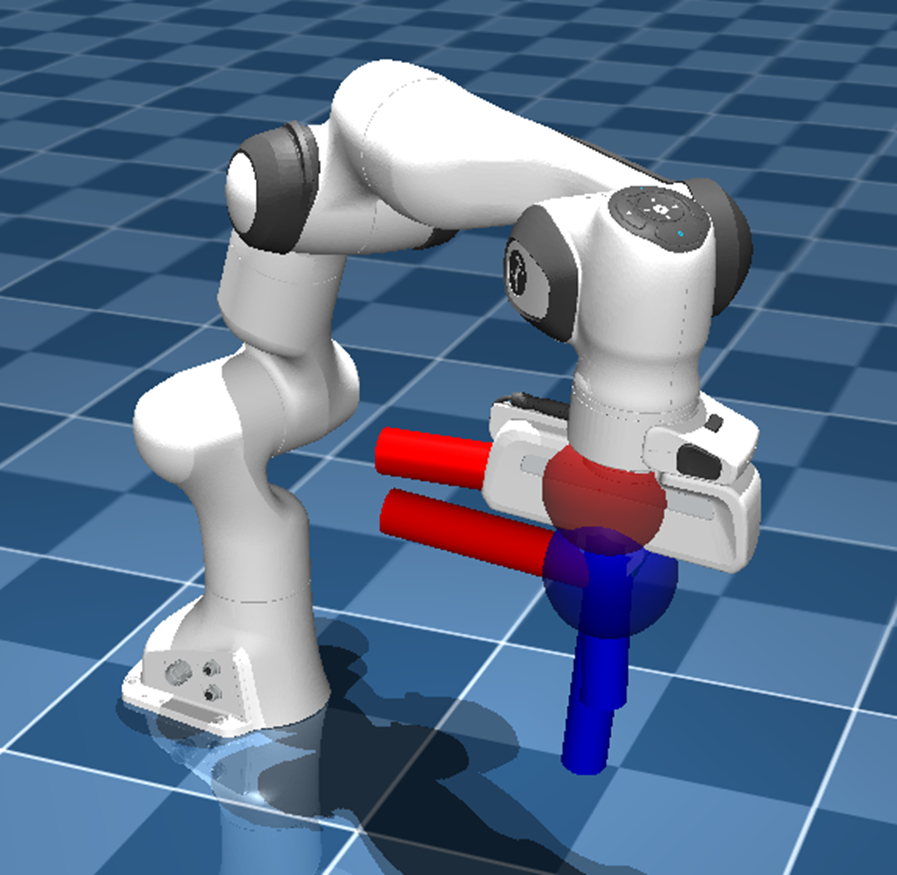 (kp = 500, kd = 50)
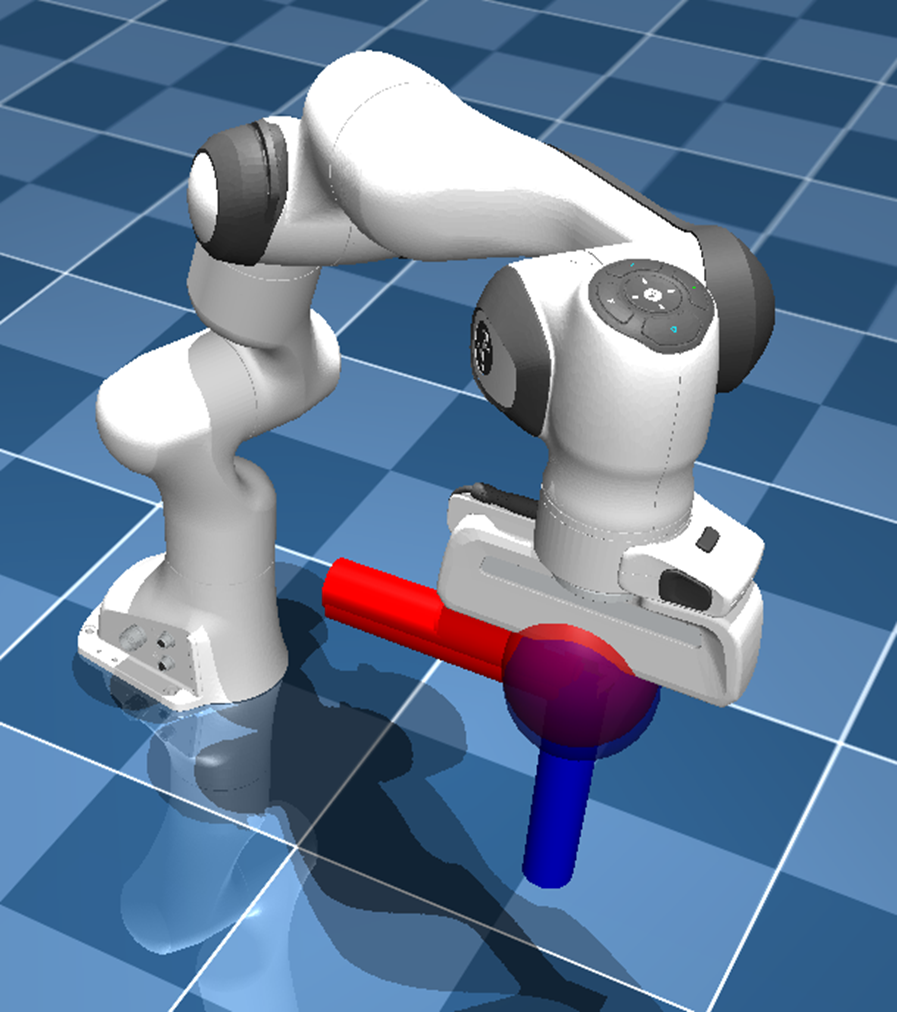 (kp = 3000, kd = 100)

In [75]:
def torque_ctrl(model, data):
    #kp = 500
    #kd = 50
    kp = 3000
    kd = 100
    
    x_des = getSitePose(model, data, "target_site")
    x_curr = getSitePose(model, data, "ee_site")
    jac = getSiteJacobian(model, data, "ee_site")    
    qpos = data.qpos
    qvel = data.qvel
    qdes = IKSolve(qpos, jac, x_des, x_curr)
    
    tau = kp * (qdes - qpos) + kd * (-qvel)
    return tau 


In [76]:
simulateCtrl(franka_torque_ctrl_sim, torque_ctrl)

## Q4 Dynamic Comp. Torque control
Create a feed forward dynamic compensation controller that calculate target $q$ from the `IKSolve` given the end-effector pose and the target site pose. Tune the PD values as best as you can. Using the provided functions for obtaining the mass matrix and dynamic bias terms. Describe what you see. 

## Response:

In dynamic comp. torque control, I could get the highest control performance. It is because, the gravity and robot's inertias are compensated by the term M and b.
So, I could observe that the robot end-effecter went to target position and this control case might have the small error. Also, the gain is relatively smaller than the just torque control case.
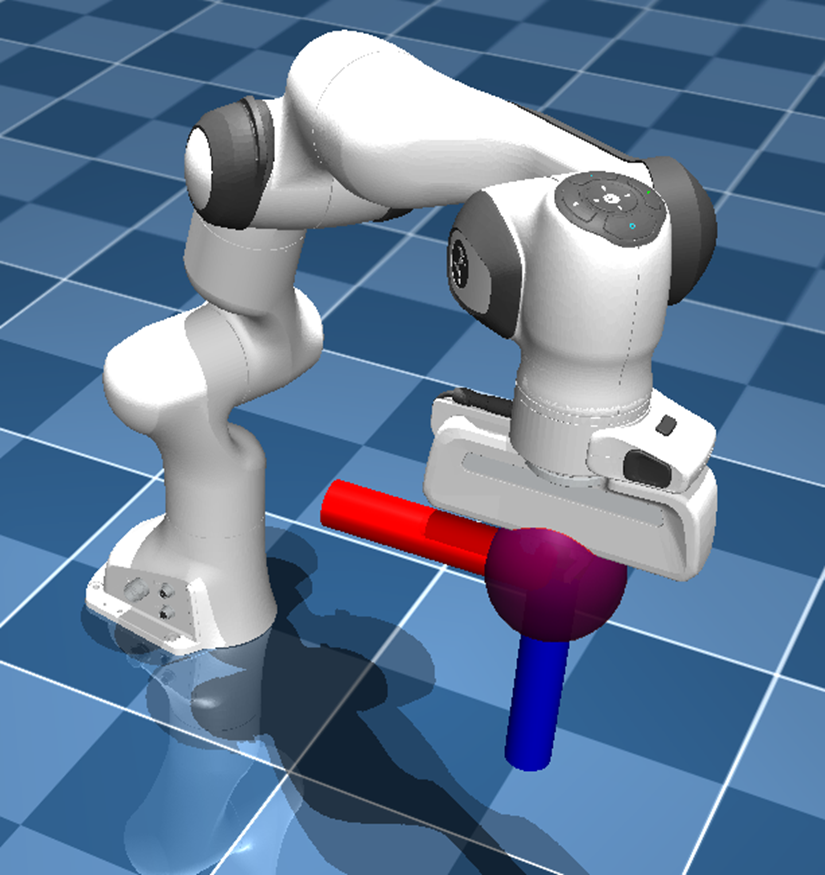

In [77]:
def getMassMatrix(model, data):
    mass_matrix = np.zeros((model.nv, model.nv))
    mujoco.mj_fullM(model, mass_matrix, data.qM)
    return mass_matrix

def getBiasTerms(model, data):
    return data.qfrc_bias

def feedforward_torque_ctrl(model, data):
    
    kp = 500
    kd = 50
    
    M = getMassMatrix(model, data)
    b = getBiasTerms(model, data)
    
    x_des = getSitePose(model, data, "target_site")
    x_curr = getSitePose(model, data, "ee_site")
    jac = getSiteJacobian(model, data, "ee_site")    
    qpos = data.qpos
    qvel = data.qvel
    qdes = IKSolve(qpos, jac, x_des, x_curr)    
    
    qddot_des = kp * (qdes - qpos) + kd * (-qvel)
    tau = M @ qddot_des + b
    #tau = qddot_des
    return tau


In [78]:
simulateCtrl(franka_torque_ctrl_sim, feedforward_torque_ctrl)